# Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math


df = pd.read_parquet("../../data/parllaw/speech_embeddings.parquet")
print(f"#Samples: {len(df)}")

#Samples: 9705


In [2]:
vocab_df = pd.read_parquet("../../data/parllaw/vocab_embeddings.parquet")

In [3]:
import json
with open("../../plotting_parameters/color_maps/color_map_block.json") as f:
    block_color_map = json.load(f)

with open("../../plotting_parameters/color_maps/color_map_party.json") as f:
    party_color_map = json.load(f)

In [4]:
df.head()

,Unnamed: 0,speaker,text,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,...,party,migration_prob,jinaai/jina-embeddings-v3,jinaai/jina-embeddings-v4,Snowflake/snowflake-arctic-embed-l-v2.0,BAAI/bge-m3,sentence-transformers/all-MiniLM-L6-v2,sentence-transformers/all-mpnet-base-v2,Qwen/Qwen3-Embedding-0.6B,google/embeddinggemma-300m
492,492,Karen Melchior,"Mr President, thank you very much to the Commi...",2024-04-24,22. Advance passenger information: enhancing a...,8,bill_26075_ID bill_26076_ID bill_26075_ID bi...,6401.0,9,False,...,ELDR/ALDE/Renew,0.393282,"[0.03173828, -0.05883789, 0.06347656, 0.061523...","[-0.017475849, -0.0234765, 0.01301684, 0.00316...","[0.029303519, 0.02908727, 0.04424794, 0.051043...","[0.00046046128, 0.041610897, -0.023090536, -0....","[0.020603927, -0.017596412, 0.0006259507, -0.0...","[0.009955298, 0.01231596, -0.031741396, 0.0164...","[-0.031322084, 0.030157333, -0.005754259, -0.0...","[-0.06368264, -0.01790871, 0.008169121, 0.0173..."
844,844,Tineke Strik,"Mr President, Commissioner. People who flee wa...",2024-04-23,17. EU-Egypt strategic and comprehensive partn...,9,,6403.0,9,False,...,Greens/EFA,0.423501,"[0.046142578, -0.076660156, 0.03930664, -0.024...","[-0.012335925, -0.012685713, 0.007637553, 0.03...","[0.0022561324, 0.03212409, 0.01491972, 0.02270...","[-0.014090479, 0.02344181, -0.032296076, 0.005...","[-0.03277658, 0.075279415, 0.00988437, -0.0314...","[0.050362997, 0.031640317, 0.0033627285, 0.010...","[0.0490291, -0.0001613221, -0.007507243, 0.003...","[-0.06358229, 0.05332363, -0.006831329, 0.0041..."
1050,1050,Anabela Rodrigues,"Senhora Presidente, em 2024, o tráfico de sere...",2024-04-22,20. Amending Directive 2011/36/EU on preventin...,10,bill_241_ID bill_241_ID,6402.0,9,False,...,NGL/The Left,0.375925,"[-0.02368164, -0.11767578, 0.041503906, -0.015...","[-0.006263365, -0.0037057083, 0.003096705, 0.0...","[0.017229473, 0.052975528, 0.015071628, -0.019...","[-0.037878938, 0.04945201, -0.028479485, 0.008...","[-3.740648e-05, 0.042549398, -0.01705076, -0.0...","[-0.016886365, 0.02107416, 0.022850083, -0.003...","[0.005645505, 0.03181904, -0.0033138462, 0.033...","[-0.049918693, -0.001202861, -0.008896867, -0...."
1054,1054,Beata Kempa,Pani Przewodnicząca! Pani Komisarz! Potrzebuje...,2024-04-22,20. Amending Directive 2011/36/EU on preventin...,14,bill_241_ID bill_241_ID,6400.0,9,False,...,ECR,0.256493,"[0.028686523, -0.09667969, 0.08251953, 0.00303...","[0.0019489997, -0.00825006, 0.032056473, 0.004...","[-0.011141846, -0.009032944, -0.04128787, 0.01...","[-0.023567535, 0.005077537, -0.07184075, 0.013...","[-0.0042979075, 0.079598755, -0.070720166, -0....","[0.0069901105, -0.003832352, 0.014021035, 0.03...","[-0.04446165, 0.02761738, -0.00755511, 0.07728...","[-0.035047594, 0.03835739, -0.051198084, 0.050..."
1056,1056,Dorien Rookmaker,"Voorzitter, dank u wel, meneer Engerer, want u...",2024-04-22,20. Amending Directive 2011/36/EU on preventin...,16,bill_241_ID bill_241_ID,6400.0,9,False,...,ECR,0.475315,"[0.02709961, -0.13085938, 0.049560547, -0.0139...","[-0.015246119, -0.009003674, 0.019220384, 0.01...","[-0.027185386, -0.015011083, 0.005534012, -0.0...","[-0.0021237587, -0.027706854, -0.04229295, 0.0...","[-0.10969446, 0.08347164, 0.015826896, -0.0843...","[0.05082612, -0.035786744, 0.014009577, 0.0413...","[-0.050546486, -0.012648543, -0.008574607, 0.0...","[-0.06766452, 0.015919995, -0.019874139, -0.01..."


In [5]:
# EMB_MODEL = "google/embeddinggemma-300m"
EMB_MODEL = "Qwen/Qwen3-Embedding-0.6B"
BLOCK_COL = "block"
PARTY_COL = "party"

# Helper Functions

In [6]:
def get_aggregated_embeddings_for_each_year(df: pd.DataFrame, embedding_column: str, aggregate_on: str):
    yearly_data = df.copy()
    yearly_data['year'] = pd.to_datetime(df['date']).dt.year
    aggregated_embeddings = yearly_data.groupby(by=[aggregate_on, 'year'])[embedding_column].agg(lambda emb: np.stack(emb).mean(axis=0) )
    return aggregated_embeddings.reset_index()


In [7]:
def get_weighted_aggregated_embeddings_for_each_year(df: pd.DataFrame, embedding_column: str, aggregate_on: str):
    yearly_data = df.copy()
    yearly_data['year'] = pd.to_datetime(df['date']).dt.year
    groupped = yearly_data.groupby(by=[aggregate_on, 'year'])
    aggregated_embeddings = groupped[[embedding_column, 'migration_prob']].apply(lambda row: np.stack(row[embedding_column]).T @ np.stack(row['migration_prob']) / sum(row['migration_prob'])).reset_index()
    aggregated_embeddings.columns = [aggregate_on, 'year', embedding_column]
    return aggregated_embeddings


In [8]:
def plot_aggregated_yearly_data(aggregated: pd.DataFrame, reduced_embeddings: np.array, target_var: str, color_map: dict):
  fig = plt.figure(figsize=(16, 9))
  ax = fig.add_subplot()
  plt.title("Two Dimensional Projection of Political Groups")

  grt = np.abs(reduced_embeddings).max() * 1.1

  ax.set_xlim(-grt, grt)
  ax.set_ylim(-grt, grt)

  scale = grt * 2


  for party in aggregated[target_var].unique():
      party_mask = aggregated[target_var] == party
      years = aggregated[party_mask]['year']
      party_embeddings = reduced_embeddings[party_mask]
      
      plt.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=color_map[party], label=party)
      for i, year in enumerate(years):
        plt.text(party_embeddings[i,0] - scale * 0.01, party_embeddings[i,1]+ scale * 0.015, f"{year}",
                  fontsize=8, bbox=dict(boxstyle="round", color=color_map[party], alpha=0.7), 
                  color='white',
                  )
  ax.legend()
  return ax

In [9]:
def closest_words_for_pc(k, eigen_vectors, vocab, probe_embs, top_n=20):
    pc_vec = eigen_vectors[k]
    pc_vec = pc_vec / np.linalg.norm(pc_vec)
    probe_embs = probe_embs
    sims = probe_embs @ pc_vec   
    
    sorted_indices = np.argsort(sims)
    pos_idx = sorted_indices[-top_n:]

    neg_idx = sorted_indices[:top_n]
    

    def map_indices_to_examples(index_list): 
        if isinstance(vocab, pd.DataFrame) or isinstance(vocab, pd.Series): 
            return [(vocab.iloc[i], sims[i]) for i in index_list]
        else:
            return [(vocab[i], sims[i]) for i in index_list]

    return map_indices_to_examples(neg_idx),  map_indices_to_examples(pos_idx)


In [10]:
def plot_pca_axis_development(axis: int, aggregated: pd.DataFrame,  target_var: str, reduced_embeddings: np.array, 
                              axis_labels: tuple[list[str]], color_map: dict,
                              top_k: int = 3):

    f = plt.figure(figsize=(10, 5))
    plt.title(f"Development of parties over the years accross Reduced-axis {axis}")

    for party in aggregated[target_var].unique():
        party_mask = aggregated[target_var] == party
        years = aggregated[party_mask]['year']
        party_embeddings = reduced_embeddings[party_mask]
        plt.plot(years, party_embeddings[:, axis], color=color_map[party], label=party)


    max_y_lim = max(abs(plt.ylim()[0]), abs(plt.ylim()[1]))

    plt.ylim((-max_y_lim, max_y_lim))  
    plt.axhline(0, linestyle="--")

    ax_label_neg = ', '.join(map(lambda x: x[0], axis_labels[0][:top_k]))
    ax_label_pos = ', '.join(map(lambda x: x[0], axis_labels[1][:top_k]))

    # label for negative axis: 
    plt.figtext(0.87, 0.2, f"[{ax_label_neg}]", horizontalalignment="right")
    # label for positive axis: 
    plt.figtext(0.87, 0.8, f"[{ax_label_pos}]", horizontalalignment="right")
    plt.legend(loc="lower left")


In [11]:
from IPython.display import display, HTML

def display_axis_semantics(axis_words: list[tuple[list[str]]]) -> None:
    data = []
    for axis, pairs in enumerate(axis_words):
        data.append({"Axis": axis, "Direction": "Neg", "Words": ", ".join([elem[0] for elem in pairs[0]])})
        data.append({"Axis": axis, "Direction": "Pos", "Words": ", ".join([elem[0] for elem in pairs[1]])})

    df = pd.DataFrame(data).set_index(["Axis", "Direction"])
    df['Words'] = df['Words'].str.wrap(100)
    display(HTML(df.to_html().replace("\\n","<br>")))

In [12]:
def display_results(eigen_vectors: np.array, aggregated: pd.DataFrame, reduced_embeddings: np.stack, target_var: str, color_map: dict) -> None:
    axis_labels_0 = closest_words_for_pc(0, eigen_vectors, vocab_df['word'], np.stack(vocab_df[EMB_MODEL]))
    axis_labels_1  = closest_words_for_pc(1, eigen_vectors, vocab_df['word'], np.stack(vocab_df[EMB_MODEL]))

    display_axis_semantics([(axis_labels_0), 
                            (axis_labels_1)])

    plot_aggregated_yearly_data(aggregated, reduced_embeddings, target_var, color_map)
    plot_pca_axis_development(0, aggregated, target_var, reduced_embeddings, axis_labels_0, color_map)
    plot_pca_axis_development(1, aggregated, target_var, reduced_embeddings, axis_labels_1, color_map)

# Defaul PCA Interpretation

In [13]:
from sklearn.decomposition import PCA

## Block-wise Comparison

In [ ]:
aggregated = get_aggregated_embeddings_for_each_year(df, EMB_MODEL, BLOCK_COL)


pca = PCA(n_components=2)
reduced = pca.fit_transform(np.stack(aggregated[EMB_MODEL]))
print(f"Explained Variance: {pca.explained_variance_.sum() * 100:.3f}%")


Explained Variance: 1.003%


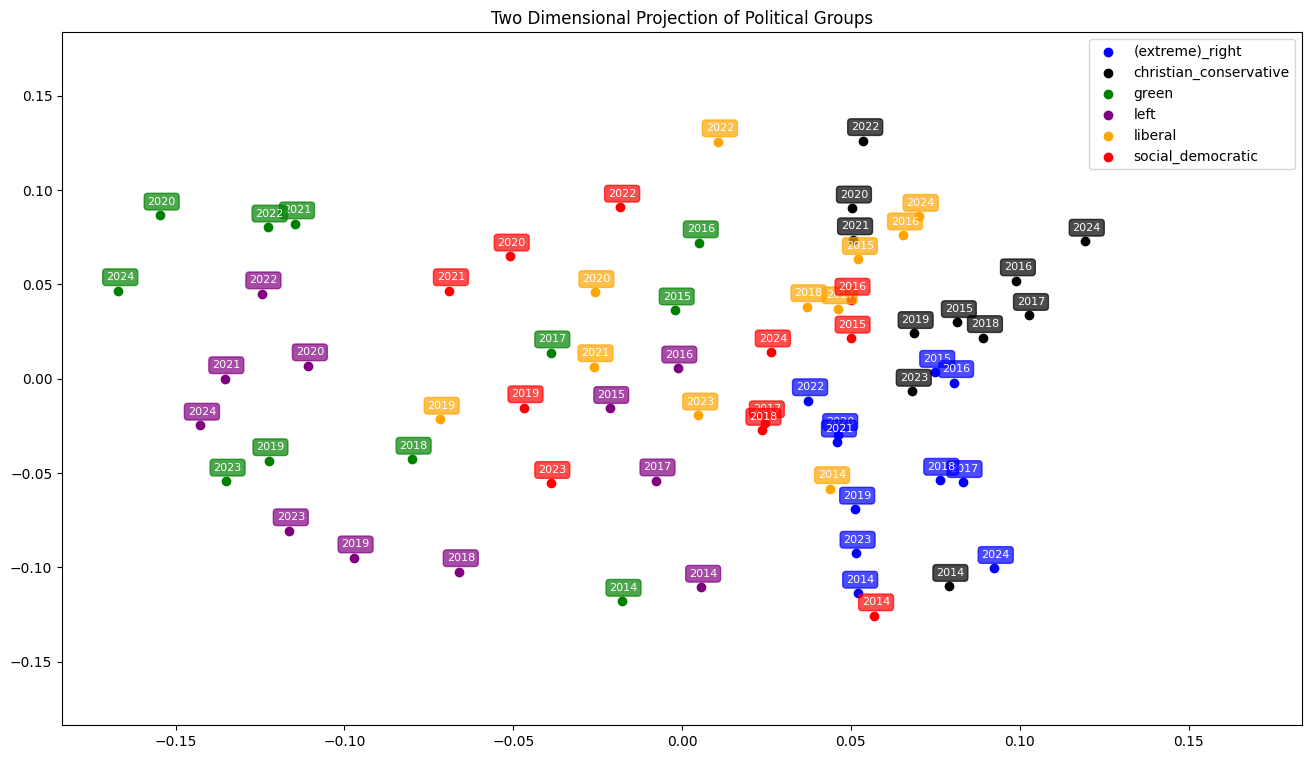

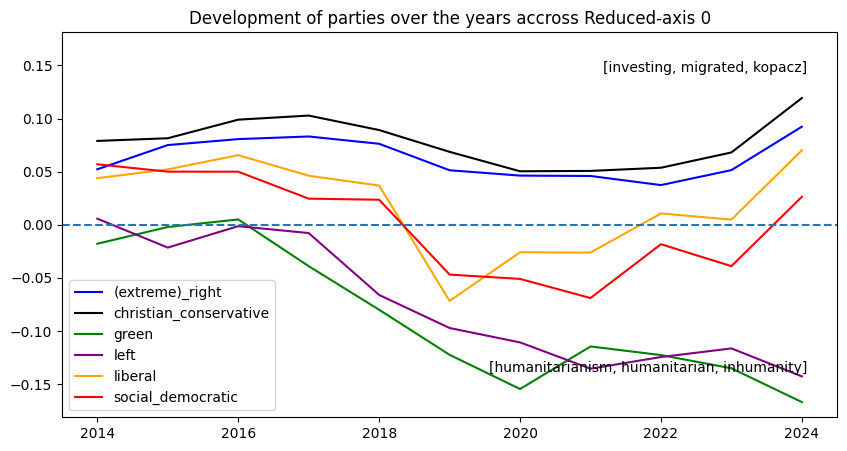

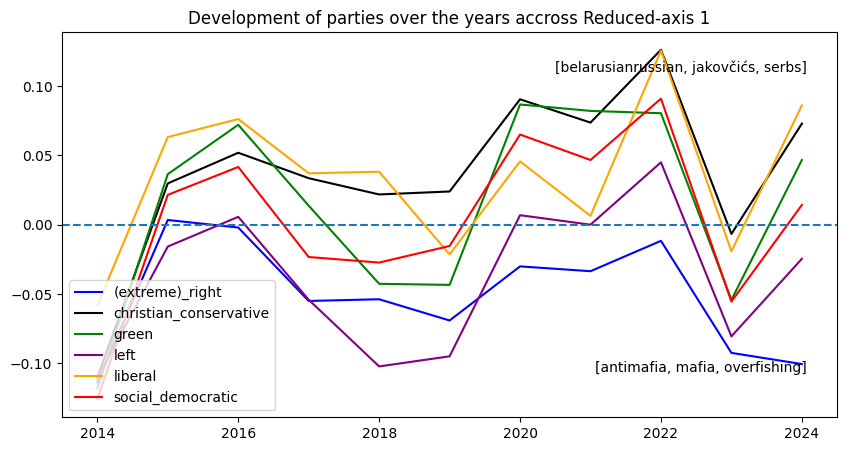

In [15]:
display_results(pca.components_, aggregated, reduced, BLOCK_COL, block_color_map)

## Party-wise Comparison

In [24]:
aggregated = get_aggregated_embeddings_for_each_year(df, EMB_MODEL, PARTY_COL)

pca = PCA(n_components=2)
reduced = pca.fit_transform(np.stack(aggregated[EMB_MODEL]))
print(f"Explained Variance: {pca.explained_variance_.sum() * 100:.3f}%")

Explained Variance: 1.542%


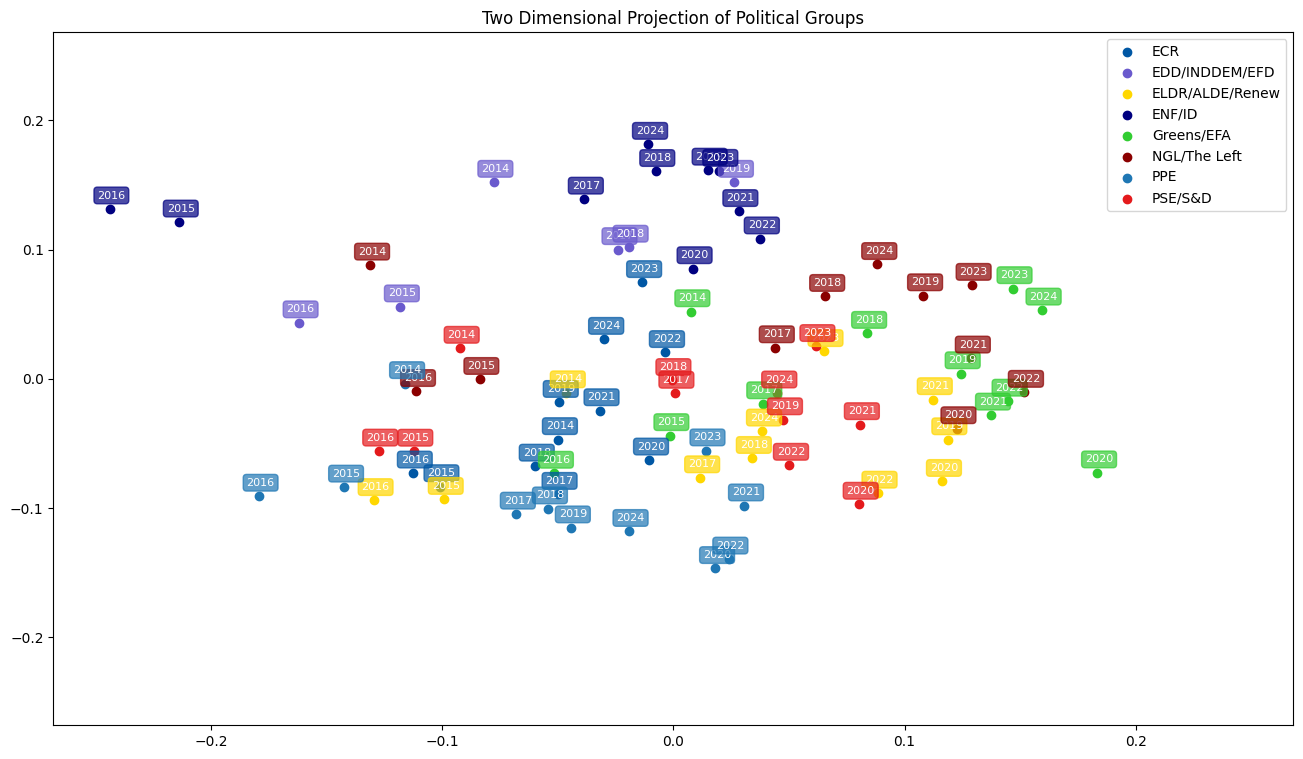

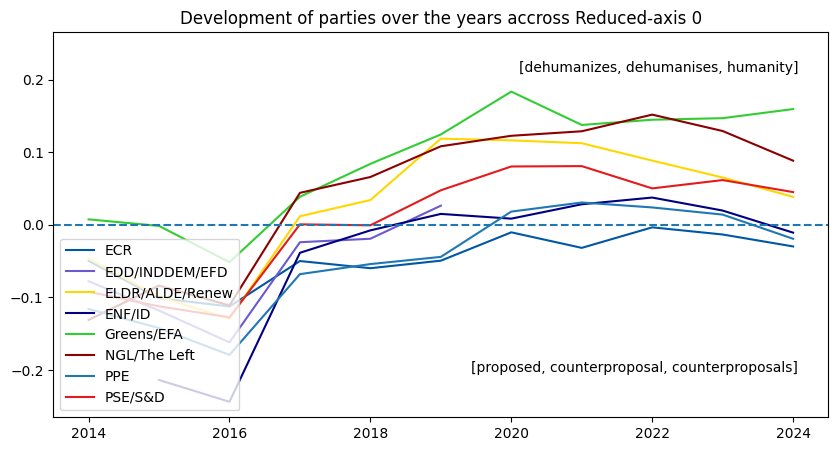

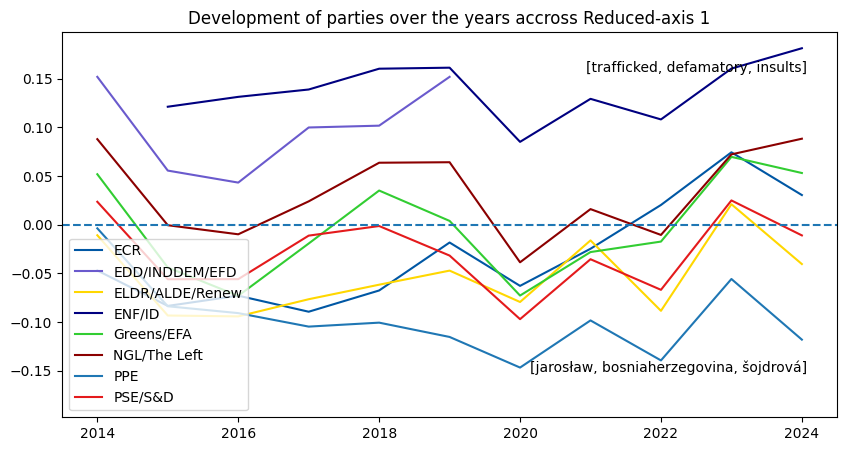

In [25]:
display_results(pca.components_, aggregated, reduced, PARTY_COL, party_color_map)

# Partial least squares regression

Identify component in our embeddings which explain our target variable (party affiliation)

## Block-wise Comparison

In [26]:
aggregated = get_aggregated_embeddings_for_each_year(df, EMB_MODEL, BLOCK_COL)

In [90]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

X = np.stack(aggregated[EMB_MODEL])



lb = LabelEncoder()
y = lb.fit_transform(aggregated[BLOCK_COL])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

print(f"#Classes {len(lb.classes_)}")

y = np.eye(len(lb.classes_))[y_train]  # create one-hot encodding to use PLS for classification PLS-DA


pls = PLSRegression(n_components=2)
pls.fit(X_train, y)

reduced = pls.transform(X)

print(f"PLS r-squared {pls.score(X_test, np.eye(len(lb.classes_))[y_test]):.3f}")


#Classes 6
PLS r-squared 0.127


In [91]:
y = lb.transform(aggregated[BLOCK_COL])


In [92]:
(pls.predict(X_test).argmax(axis=1) == y_test).mean() * 100

np.float64(7.142857142857142)

In [93]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

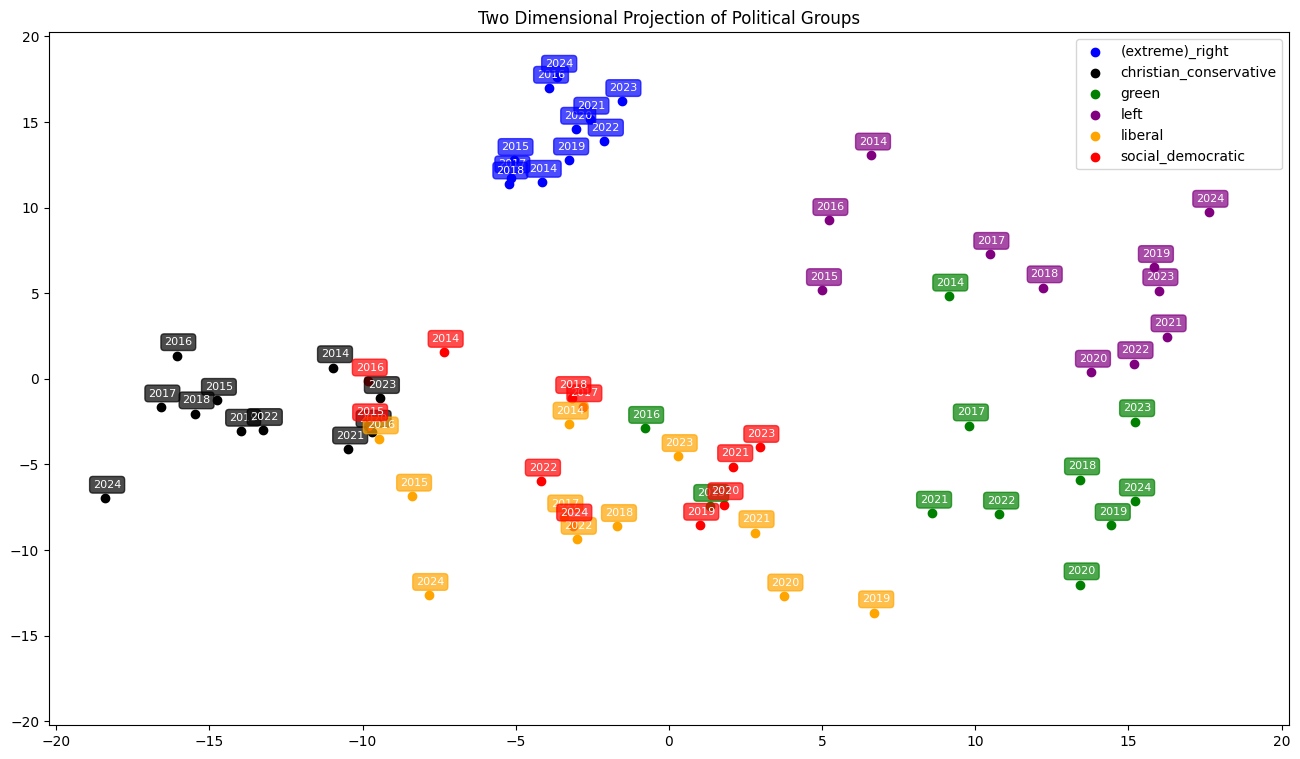

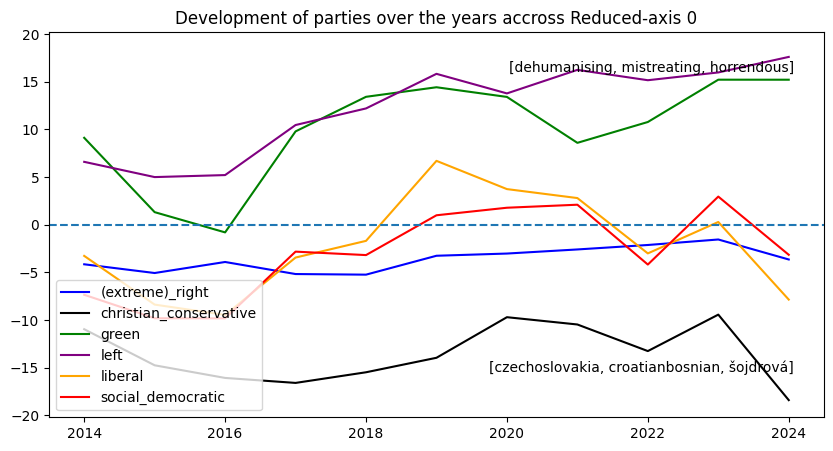

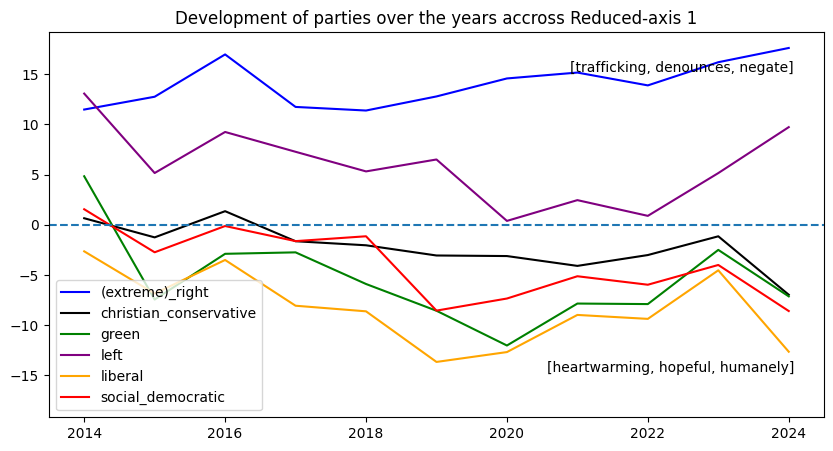

In [28]:
display_results(pls.x_weights_.T, aggregated, reduced, BLOCK_COL, block_color_map)

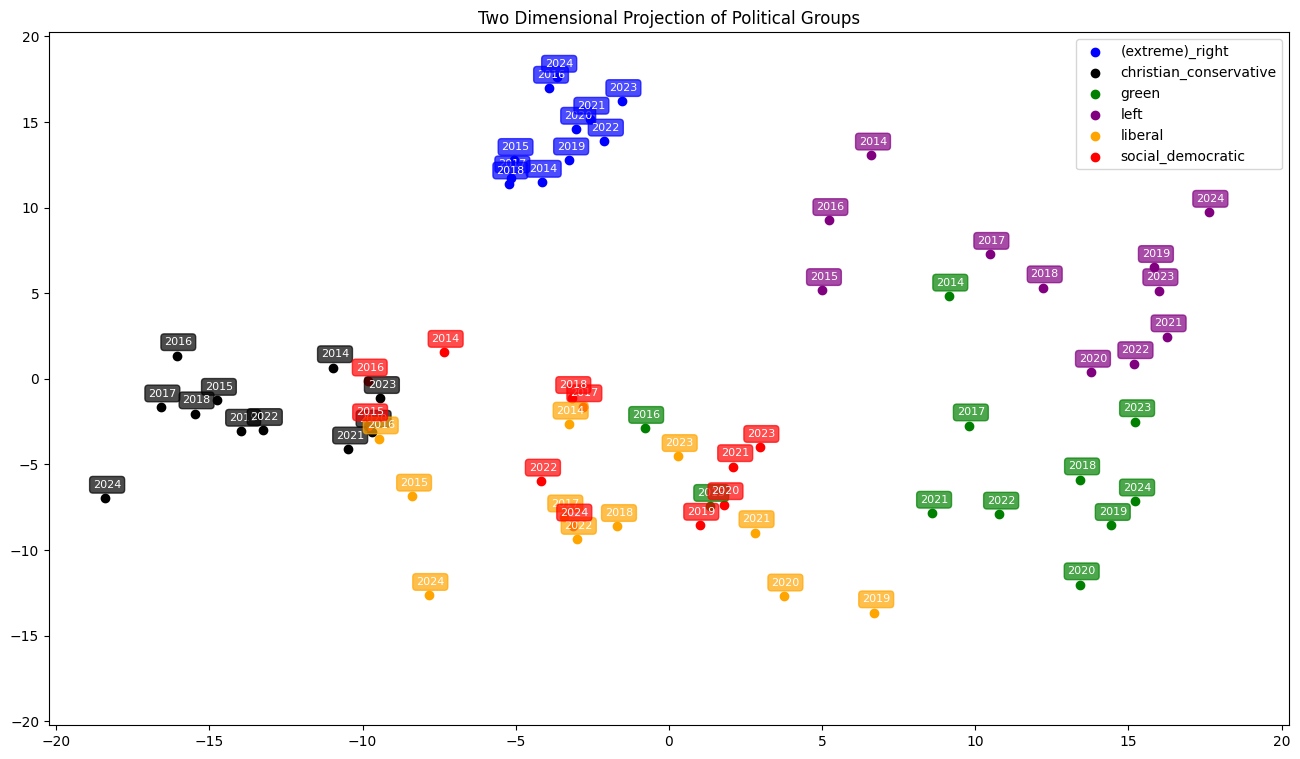

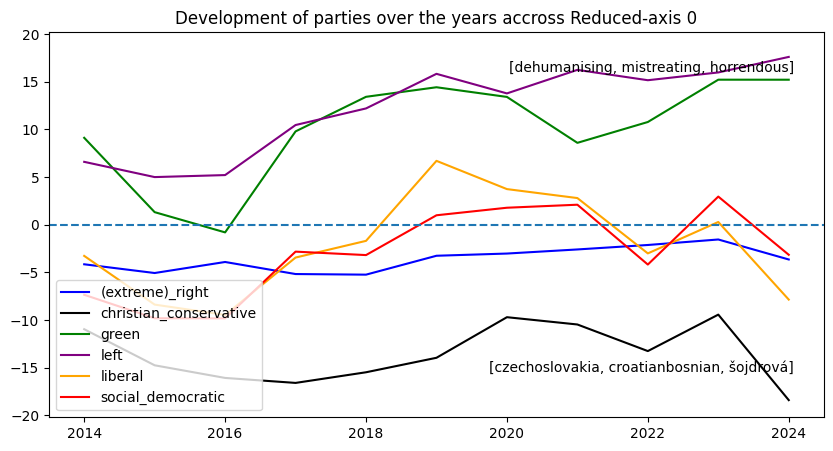

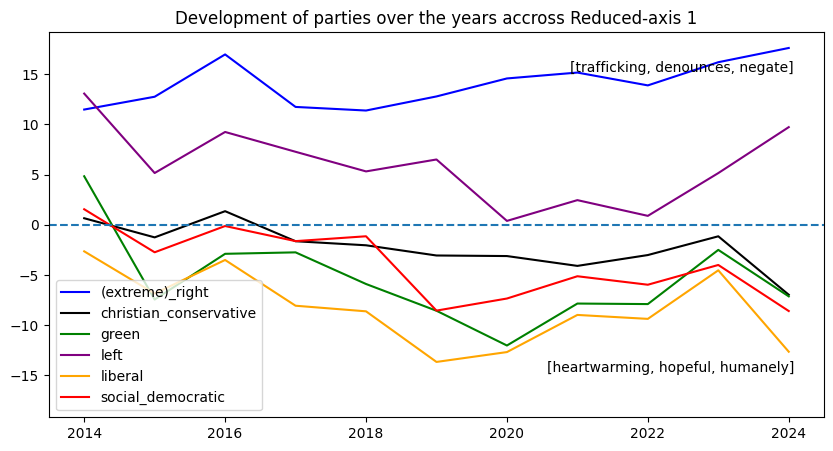

In [29]:
display_results(pls.x_weights_.T, aggregated, reduced, BLOCK_COL, block_color_map)

## Party-wise comparison

In [30]:
aggregated = get_aggregated_embeddings_for_each_year(df, EMB_MODEL, PARTY_COL)

In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import PLSRegression

X = np.stack(aggregated[EMB_MODEL])

lb = LabelEncoder()
y = lb.fit_transform(aggregated[PARTY_COL])

print(f"#Classes {len(lb.classes_)}")

y = np.eye(len(lb.classes_))[y]  # create one-hot encodding to use PLS for classification PLS-DA


pls = PLSRegression(n_components=2)
pls.fit(X, y)

reduced = pls.transform(X)


print(f"PLS r-squared {pls.score(X, y):.3f}")


#Classes 8
PLS r-squared 0.244


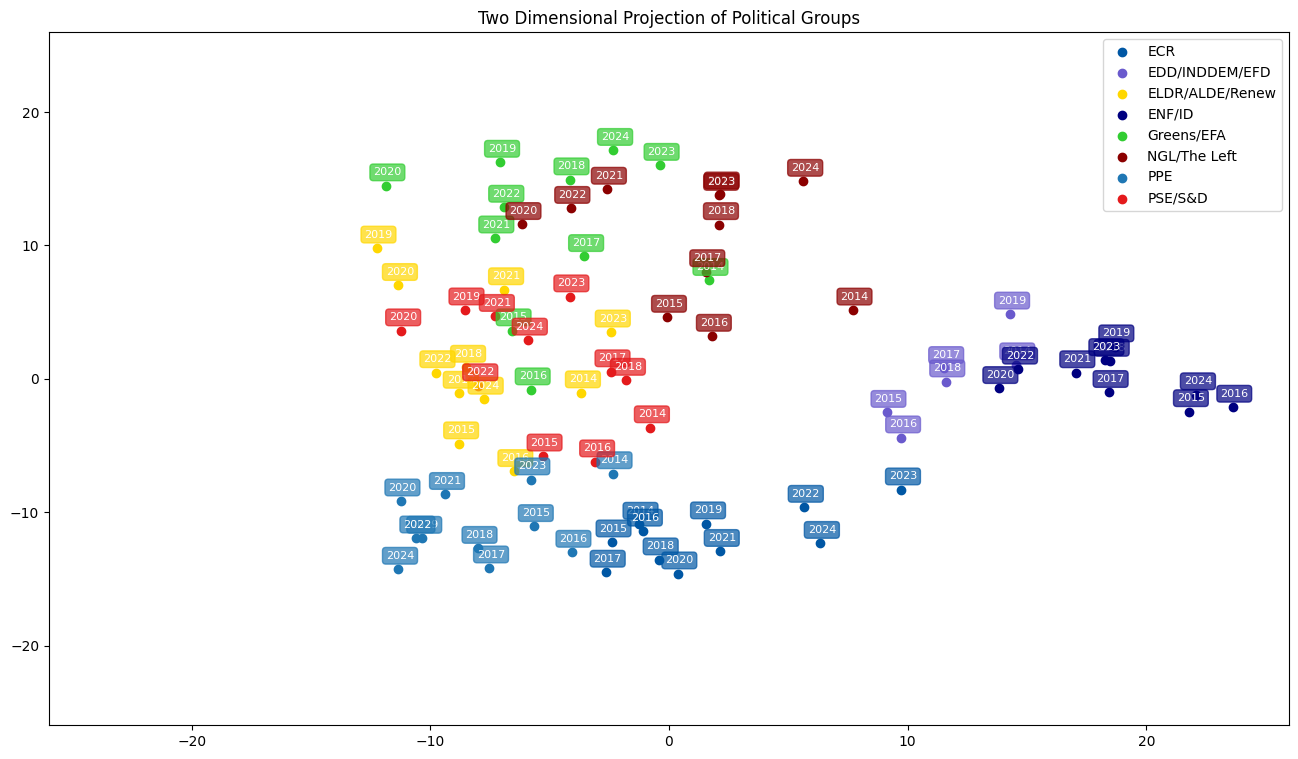

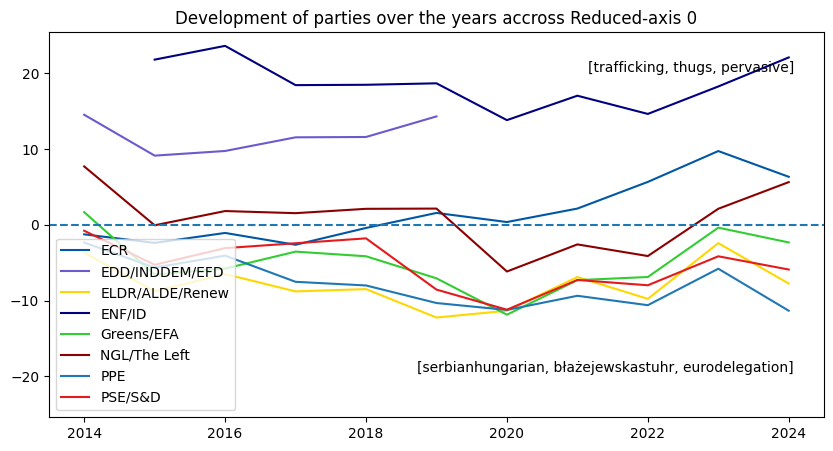

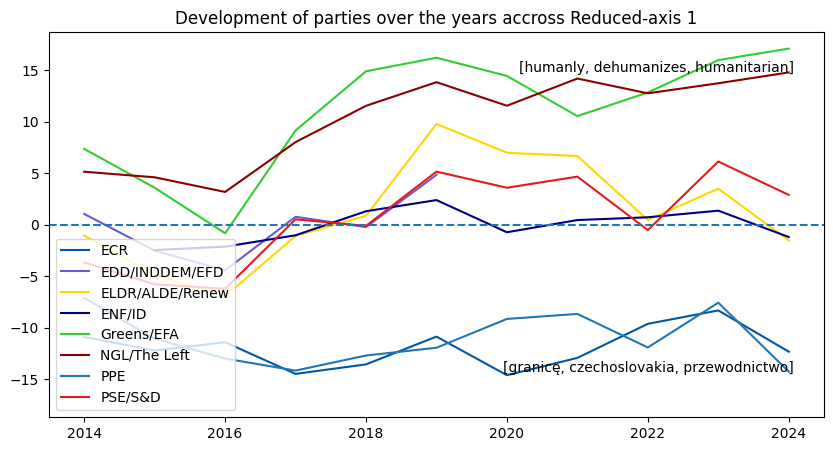

In [34]:
display_results(pls.x_weights_.T, aggregated, reduced, PARTY_COL, party_color_map)

## Migration Related Axis + Weighted Centroid Embeddings

In [22]:
pd.to_datetime(df.date).dt.year

492       2024
844       2024
1050      2024
1054      2024
1056      2024
          ... 
291519    2014
291861    2014
292003    2014
292004    2014
292025    2014
Name: date, Length: 9705, dtype: int32

In [42]:
aggregated = get_aggregated_embeddings_for_each_year(df, EMB_MODEL, BLOCK_COL)

In [45]:
aggregated.head()

,block,year,Qwen/Qwen3-Embedding-0.6B
0,(extreme)_right,2014,"[-0.002843225, 0.014559195, -0.006324447, 0.00..."
1,(extreme)_right,2015,"[0.002586444, -0.0039931443, -0.0069103274, 0...."
2,(extreme)_right,2016,"[0.0023387661, -0.011009981, -0.006688836, 0.0..."
3,(extreme)_right,2017,"[-0.0078049344, -0.0041489205, -0.0076990123, ..."
4,(extreme)_right,2018,"[-0.007279029, 0.004421704, -0.007069691, 0.01..."


In [46]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import PLSRegression

X = np.stack(aggregated[EMB_MODEL])

lb = LabelEncoder()
y_party = lb.fit_transform(aggregated[BLOCK_COL])



y_party = np.eye(len(lb.classes_))[y_party] 

lb = LabelEncoder()

y_year =  lb.fit_transform(aggregated.year)
y_year = np.eye(len(lb.classes_))[y_year]

y = np.concat([y_year, y_party], axis=1)



In [47]:
pls = PLSRegression(n_components=2)
pls.fit(X, y)


print(f"PLS r-squared {pls.score(X, y):.3f}")

PLS r-squared 0.124


In [ ]:
pls.transform(X)

### Party

In [48]:
aggregated = get_weighted_aggregated_embeddings_for_each_year(df, EMB_MODEL, PARTY_COL)
reduced = pls.transform(np.stack(aggregated[EMB_MODEL]))

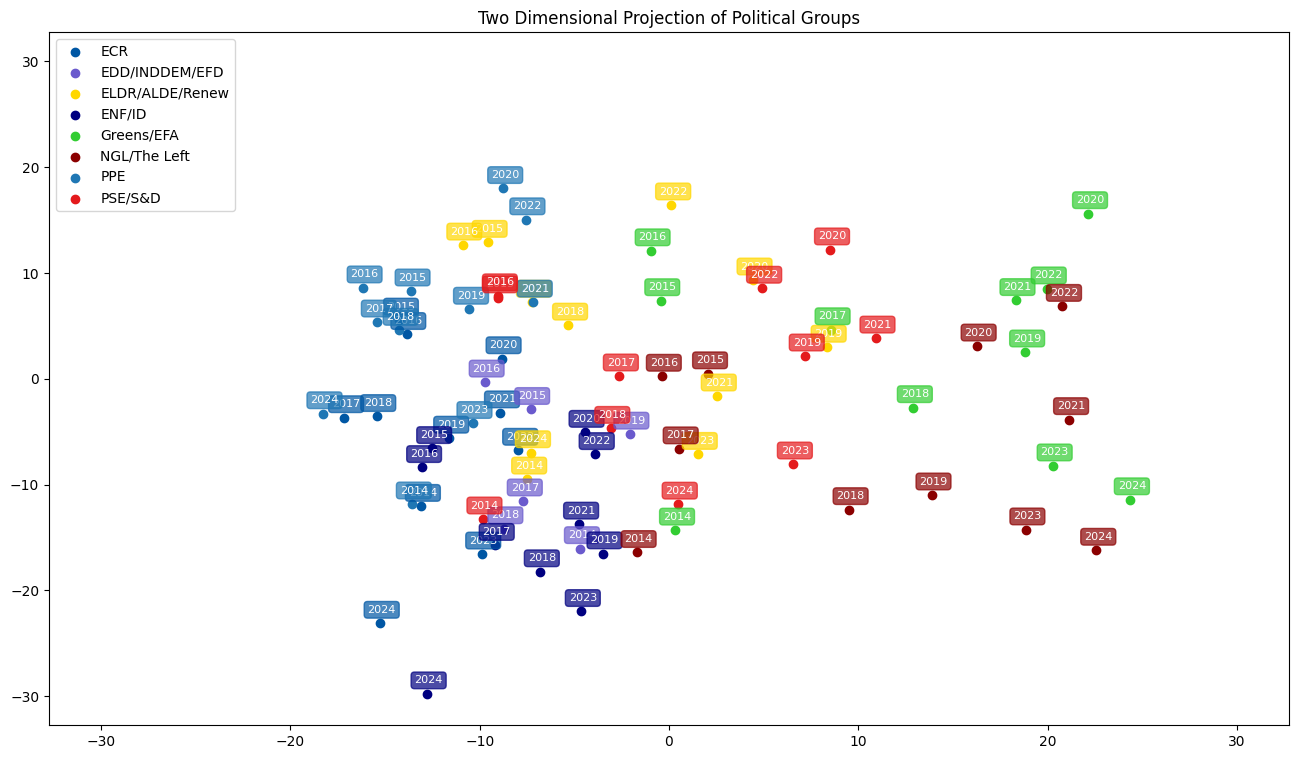

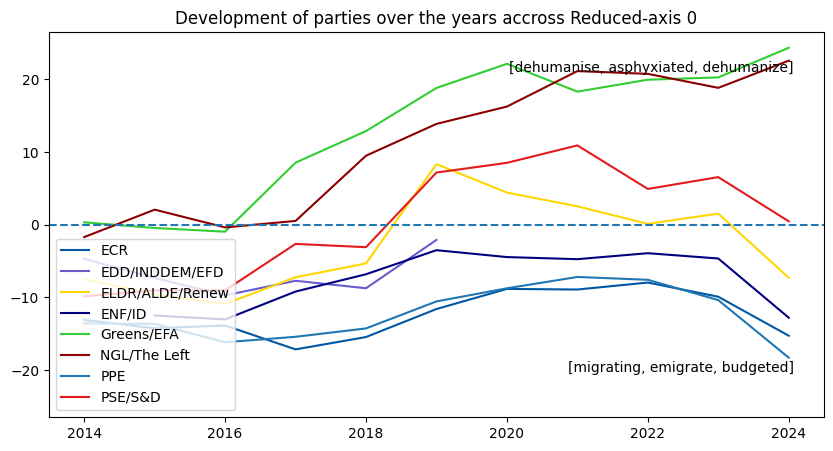

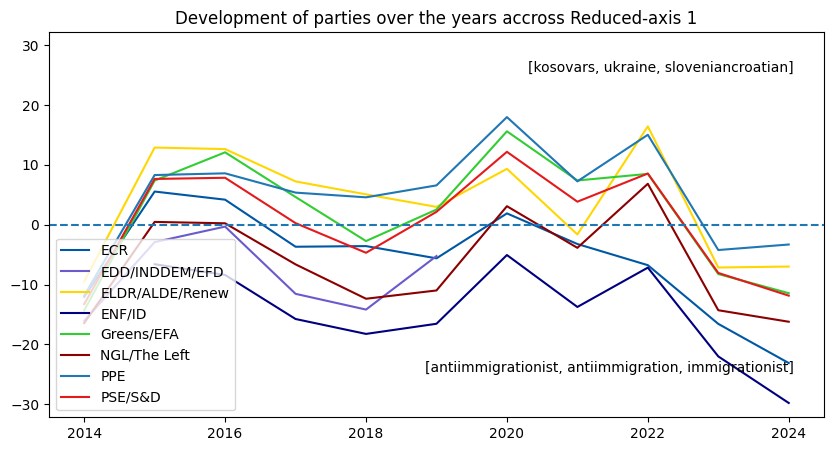

In [49]:
display_results(pls.x_weights_.T, aggregated, reduced, PARTY_COL, party_color_map)

### Block

In [50]:
aggregated = get_weighted_aggregated_embeddings_for_each_year(df, EMB_MODEL, BLOCK_COL)
reduced = pls.transform(np.stack(aggregated[EMB_MODEL]))

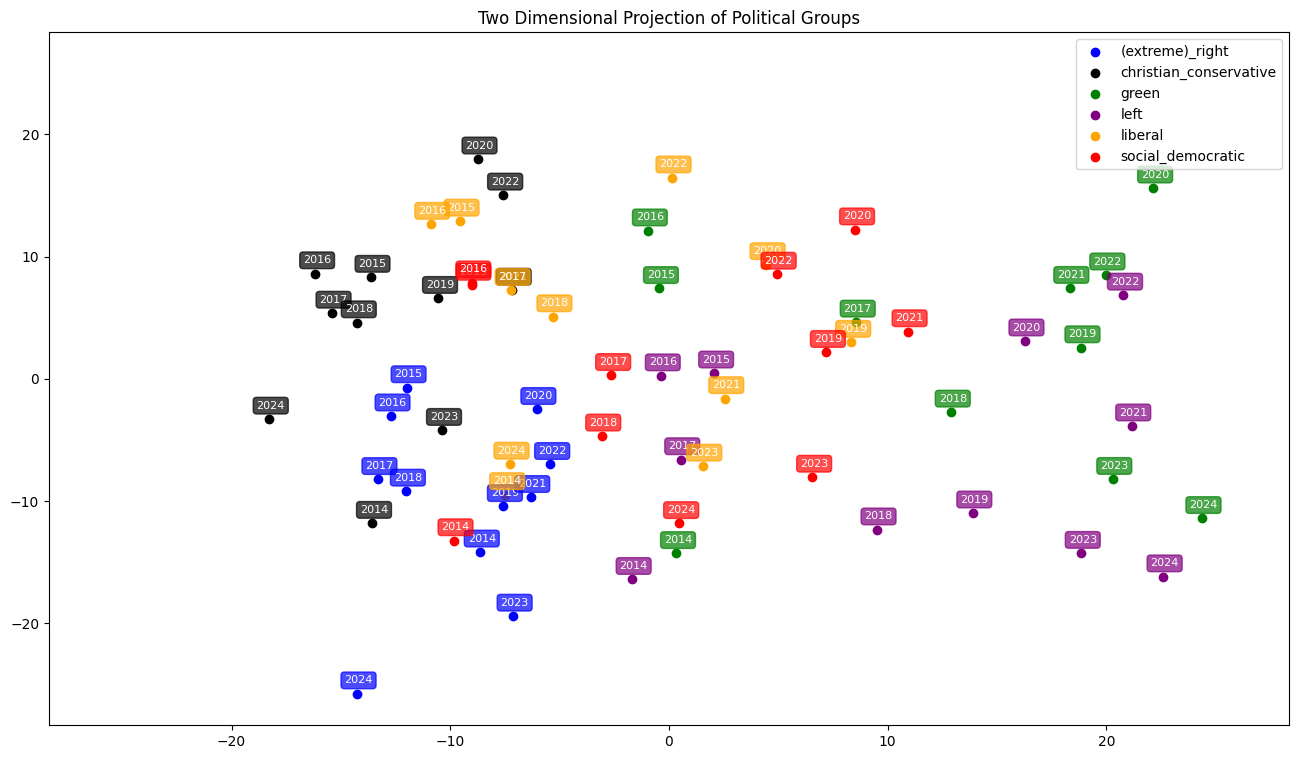

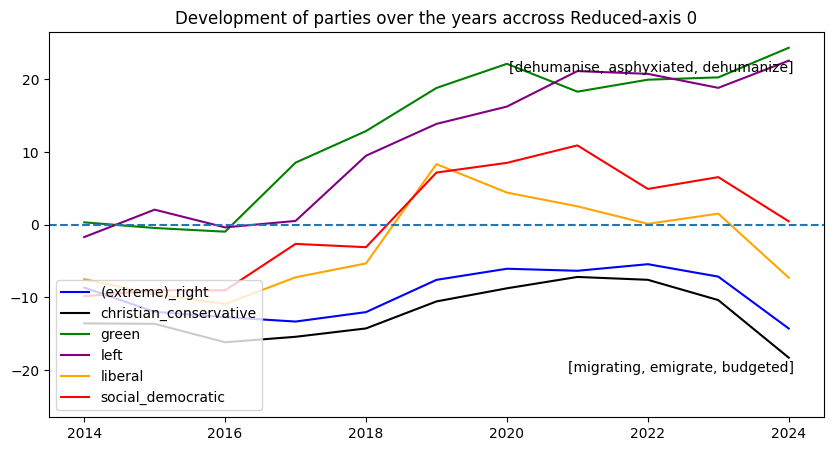

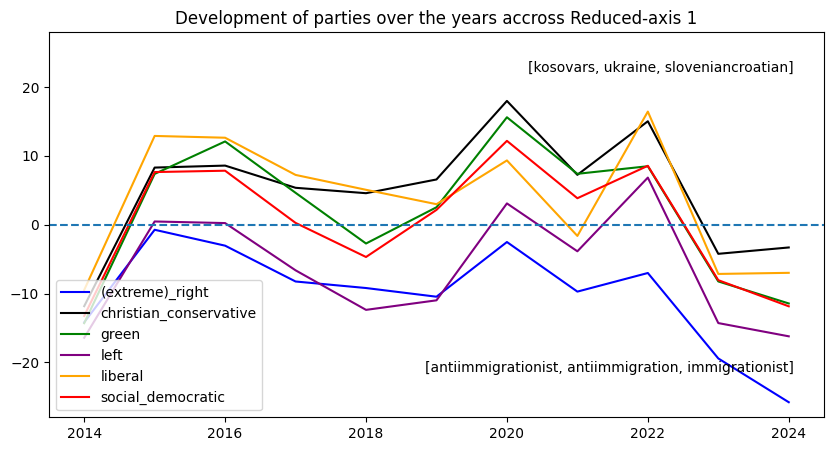

In [51]:
display_results(pls.x_weights_.T, aggregated, reduced, BLOCK_COL, block_color_map)

# Principal Component Regression 

Selecting PCs in a way that maximizes R<sup>2</sup> Lott (1973) 

## PCs that explain block differences

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


aggregated = get_aggregated_embeddings_for_each_year(df, EMB_MODEL, BLOCK_COL)

X = StandardScaler().fit_transform(np.stack(df[EMB_MODEL]))

lb = LabelEncoder()
y = lb.fit_transform(df[BLOCK_COL])

print(f"#Classes {len(lb.classes_)}")


#Classes 6


In [41]:

from tqdm import tqdm
pca = PCA(n_components=49)
X_pca =  pca.fit_transform(X)

results = np.zeros((49, 49))

for pc_1 in tqdm(range(49)):
    for pc_2 in range(pc_1 + 1, 49):
        pcr = LogisticRegression()
        pcr.fit(X_pca[:, [pc_1, pc_2]], y)
        results[pc_1, pc_2] = pcr.score(X_pca[:, [pc_1, pc_2]], y) 



100%|██████████| 49/49 [01:13<00:00,  1.51s/it]


In [42]:
pcs = np.unravel_index(results.argmax(), shape=(49, 49))
print(f"PCA axis: {pcs}")

PCA axis: (np.int64(1), np.int64(8))


In [43]:

reduced = X_pca[:, pcs]

In [44]:
pca.components_[pcs, :].shape

(2, 768)

In [45]:
axis_labels_0 = closest_words_for_pc(0, pca.components_[pcs, :], vocab_df['word'], np.stack(vocab_df[EMB_MODEL]))
axis_labels_1  = closest_words_for_pc(1, pca.components_[pcs, :], vocab_df['word'], np.stack(vocab_df[EMB_MODEL]))

In [46]:
display_axis_semantics([(axis_labels_0), 
                        (axis_labels_1)])

In [52]:
X_ind = StandardScaler().fit_transform(np.stack(aggregated[EMB_MODEL]))
reduced_ind = pca.transform(X_ind)[:, pcs]

<Axes: title={'center': 'Two Dimensional Projection of Political Groups'}>

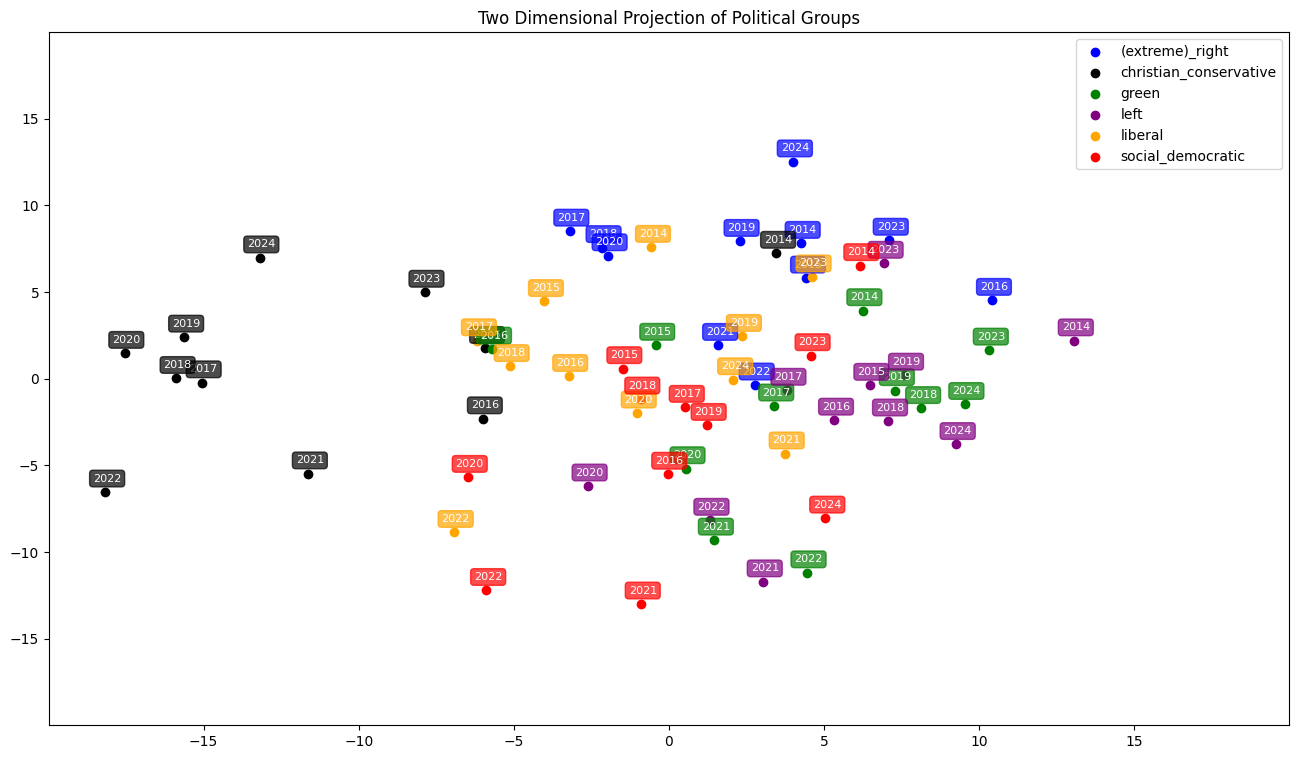

In [53]:
plot_aggregated_yearly_data(aggregated, reduced_ind, BLOCK_COL, block_color_map)

## PCs that explain migration

In [54]:
from sklearn.linear_model import LinearRegression


X = StandardScaler().fit_transform(np.stack(df[EMB_MODEL]))

y = np.stack(df['migration_prob'])


In [55]:
pca = PCA(n_components=49)
X_pca =  pca.fit_transform(X)

results = np.zeros((49, 49))

for pc_1 in tqdm(range(49)):
    for pc_2 in range(pc_1 + 1, 49):
        pcr = LinearRegression()
        pcr.fit(X_pca[:, [pc_1, pc_2]], y)
        results[pc_1, pc_2] = pcr.score(X_pca[:, [pc_1, pc_2]], y) 


100%|██████████| 49/49 [00:00<00:00, 63.94it/s]


In [56]:
pcs = np.unravel_index(results.argmax(), shape=(49, 49))
print(f"PCA axis: {pcs}")

PCA axis: (np.int64(8), np.int64(13))


In [57]:
results.max()

np.float64(0.11714416743728606)

In [58]:
axis_labels_0 = closest_words_for_pc(0, pca.components_[pcs, :], vocab_df['word'], np.stack(vocab_df[EMB_MODEL]))
axis_labels_1  = closest_words_for_pc(1, pca.components_[pcs, :], vocab_df['word'], np.stack(vocab_df[EMB_MODEL]))

In [59]:
display_axis_semantics([(axis_labels_0), 
                        (axis_labels_1)])

### Weighted Centroids

<Axes: title={'center': 'Two Dimensional Projection of Political Groups'}>

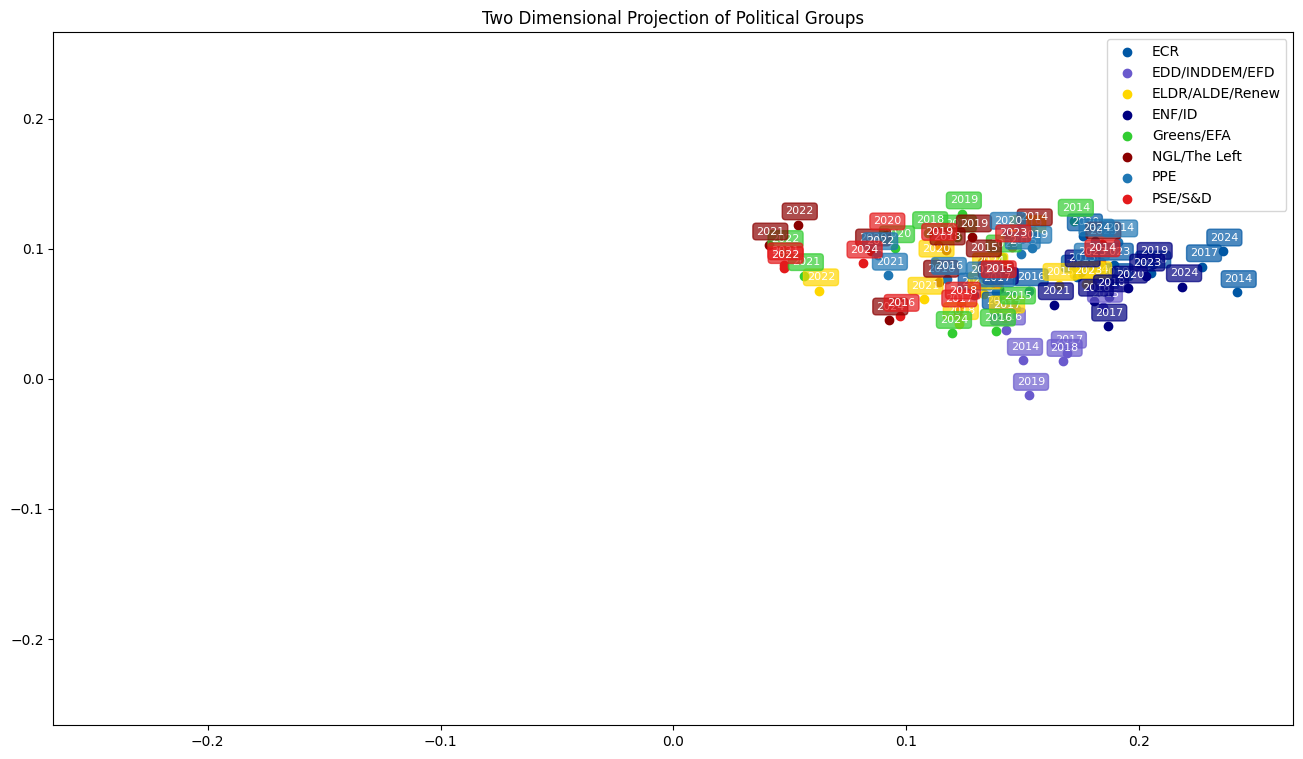

In [60]:
aggregated = get_weighted_aggregated_embeddings_for_each_year(df, EMB_MODEL, PARTY_COL)
reduced = pca.transform(np.stack(aggregated[EMB_MODEL]))[:, pcs]
plot_aggregated_yearly_data(aggregated, reduced, PARTY_COL, party_color_map)

### Mean Centroids

<Axes: title={'center': 'Two Dimensional Projection of Political Groups'}>

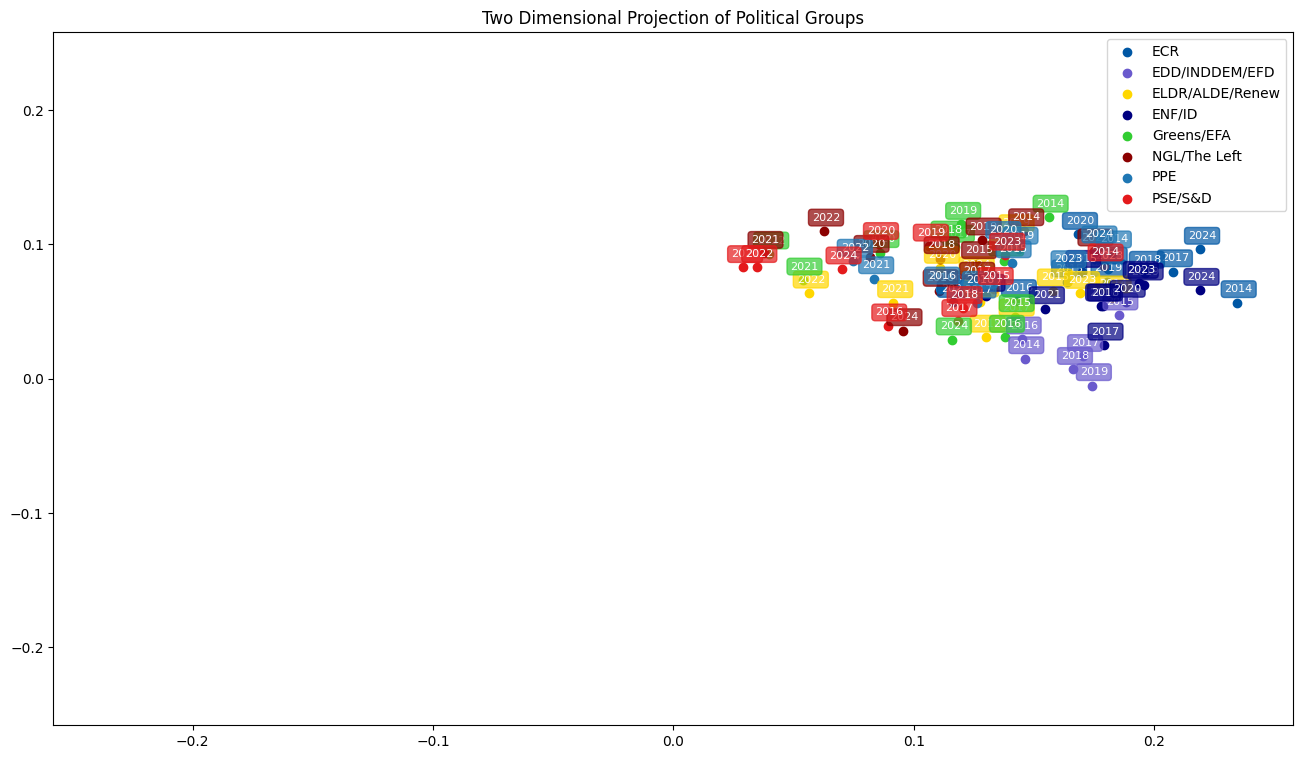

: 

In [ ]:
aggregated = get_aggregated_embeddings_for_each_year(df, EMB_MODEL, PARTY_COL)
reduced = pca.transform(np.stack(aggregated[EMB_MODEL]))[:, pcs]
plot_aggregated_yearly_data(aggregated, reduced, PARTY_COL, party_color_map)

# Weighted Centroids

In [ ]:
aggregated = get_weighted_aggregated_embeddings_for_each_year(df, EMB_MODEL, BLOCK_COL)


pca = PCA(n_components=2)
reduced = pca.fit_transform(np.stack(aggregated[EMB_MODEL]))
print(f"Explained Variance: {pca.explained_variance_.sum() * 100:.3f}%")

Explained Variance: 1.461%


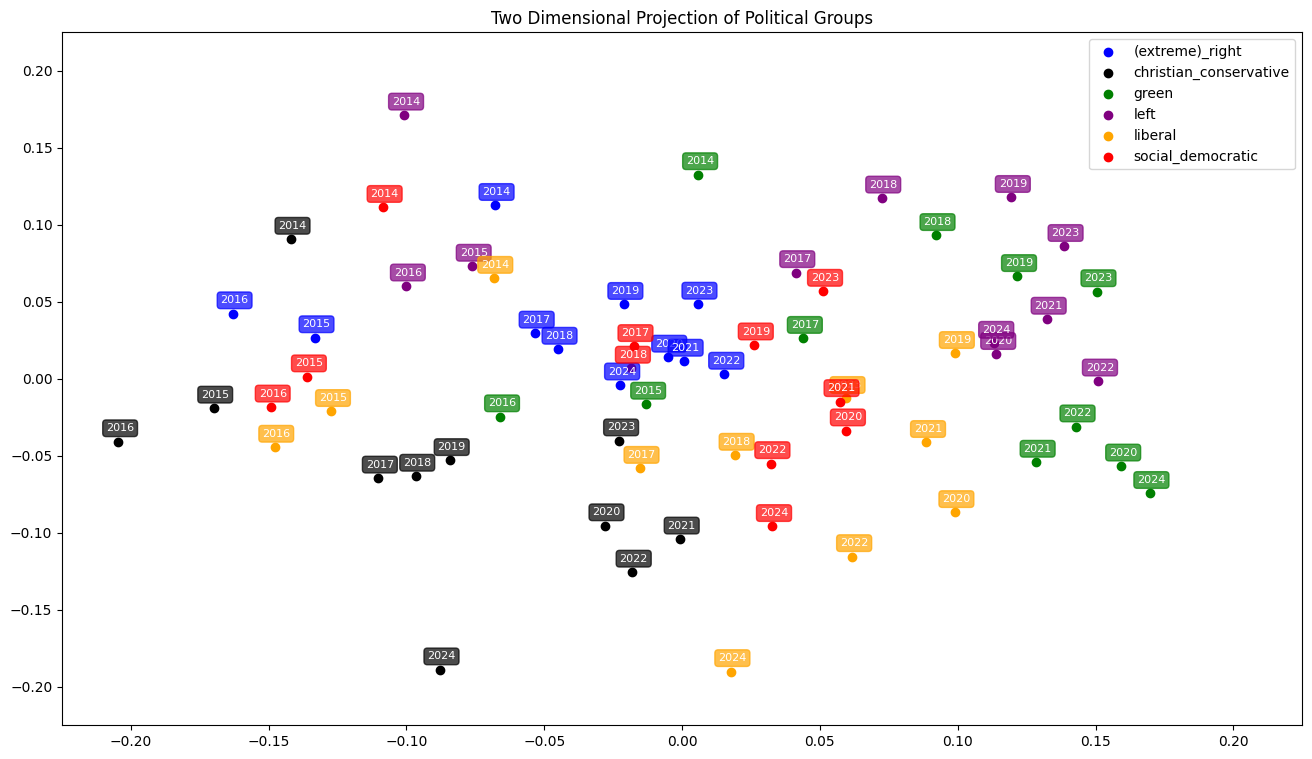

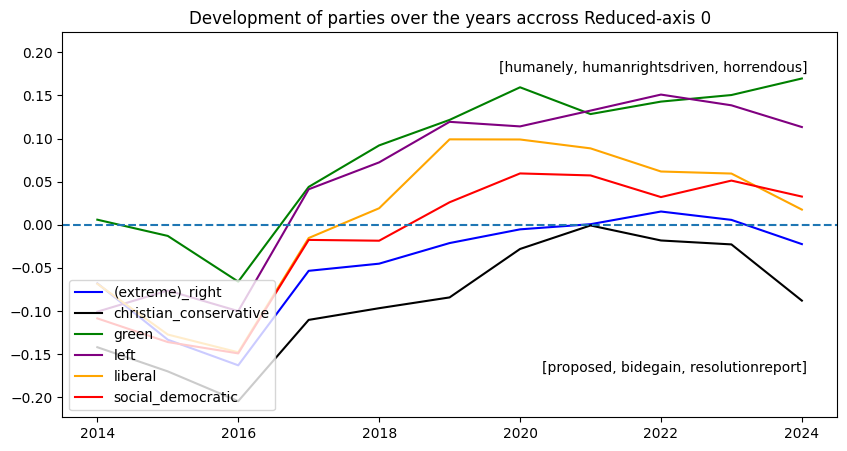

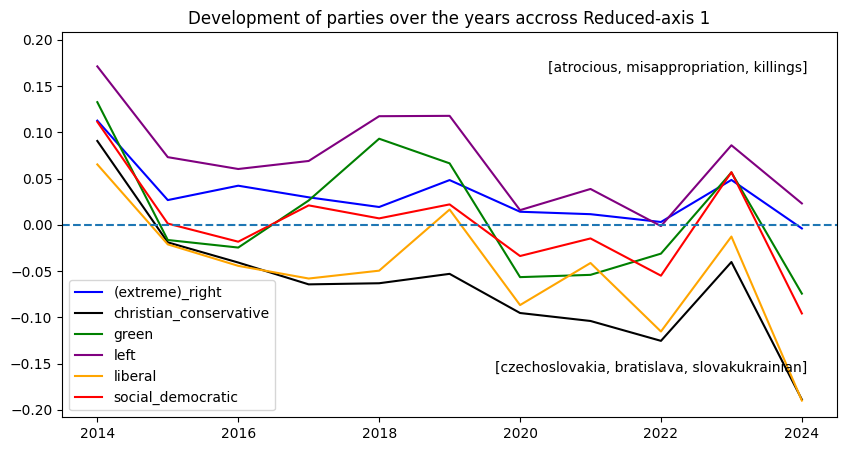

In [ ]:
display_results(pca.components_, aggregated, reduced, BLOCK_COL, block_color_map)

In [ ]:
aggregated = get_weighted_aggregated_embeddings_for_each_year(df, EMB_MODEL, PARTY_COL)


pca = PCA(n_components=2)
reduced = pca.fit_transform(np.stack(aggregated[EMB_MODEL]))
print(f"Explained Variance: {pca.explained_variance_.sum() * 100:.3f}%")

Explained Variance: 1.597%


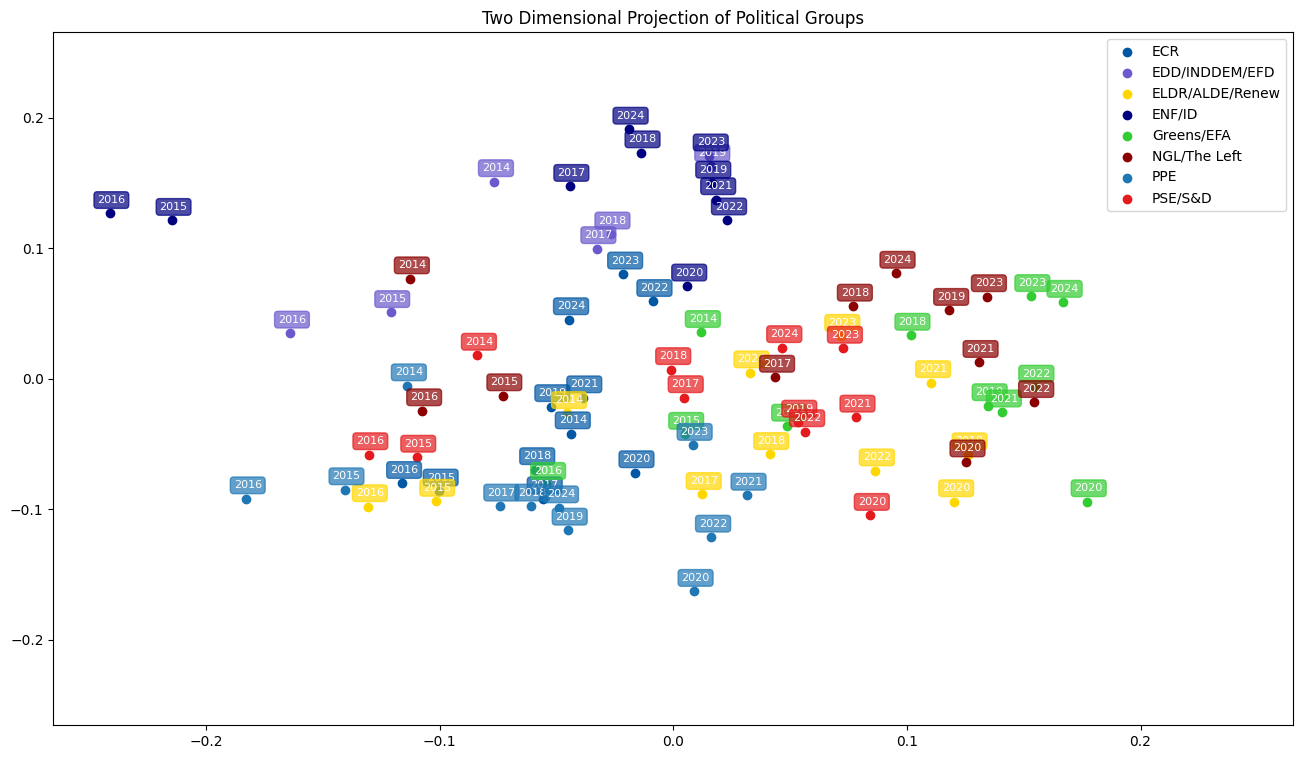

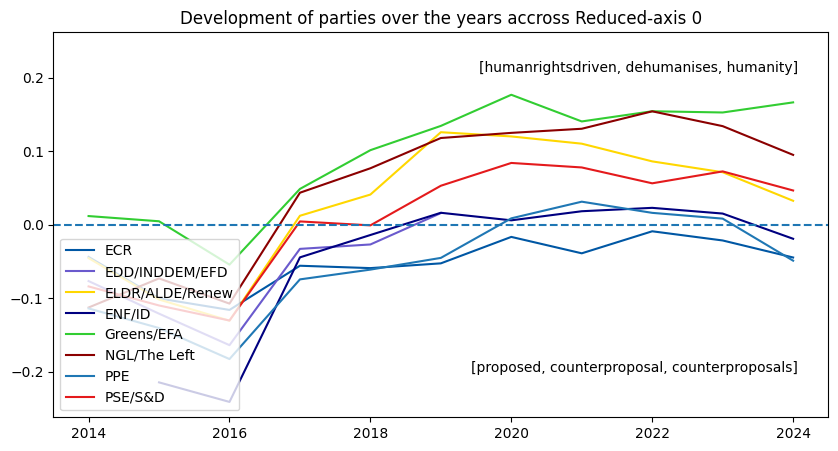

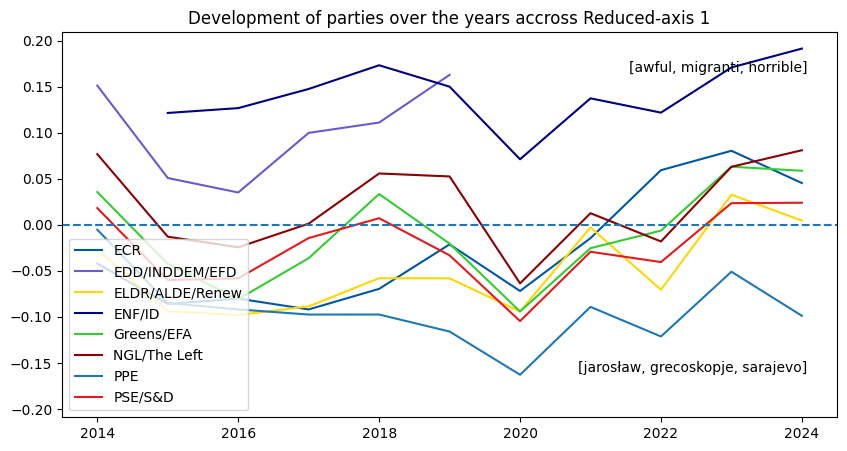

In [ ]:
display_results(pca.components_, aggregated, reduced, PARTY_COL, party_color_map)